In [1]:
!pip install gseapy

In [2]:
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gseapy.plot import gseaplot

/Users/shahjess/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
def create_ranking(df):
    df_ranking = df[['Gene', 'log2FoldChange']]
    df_ranking.set_index('Gene', inplace=True)
    return df_ranking

def GSEA(ranking):
    # Perform the analysis for the given ranking
    pre_res = gp.prerank(rnk=ranking,
                         gene_sets='GO_Biological_Process_2021',
                         threads=4,
                         min_size=5,
                         max_size=1000,
                         permutation_num=1000,
                         outdir=None,
                         seed=6,
                         verbose=True)

    out = []
    for term in list(pre_res.results):
        out.append([
            term,
            pre_res.results[term]['fdr'],
            pre_res.results[term]['es'],
            pre_res.results[term]['nes'],
            pre_res.results[term]['gene %'],
            pre_res.results[term]['lead_genes']
        ])

    out_df = pd.DataFrame(out, columns=['Term', 'fdr', 'es', 'nes', 'gene %', 'lead_genes']).sort_values('nes').reset_index(drop=True)

    # Calculate absolute NES values and sort by NES in descending order
    out_df['abs_nes'] = abs(out_df['nes'])
    out_df = out_df.sort_values('nes', ascending=False).reset_index(drop=True)
    out_df.drop('abs_nes', axis=1, inplace=True)

    return out_df

In [6]:
e = pd.read_csv('../data/essential_CM.tsv', delimiter='\t')

In [7]:
samples = [e]

results = []  # List to store GSEA results for each sample

for sample in samples:
  ranking = create_ranking(sample)
  gsea_result = GSEA(ranking)
  results.append(gsea_result)

2024-04-12 17:30:11,021 [INFO] Parsing data files for GSEA.............................
2024-04-12 17:30:11,021 [INFO] Enrichr library gene sets already downloaded in: /Users/shahjess/.cache/gseapy, use local file
2024-04-12 17:30:11,058 [INFO] 5503 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-12 17:30:11,058 [INFO] 0533 gene_sets used for further statistical testing.....
2024-04-12 17:30:11,058 [INFO] Start to run GSEA...Might take a while..................
2024-04-12 17:30:11,564 [INFO] Congratulations. GSEApy runs successfully................



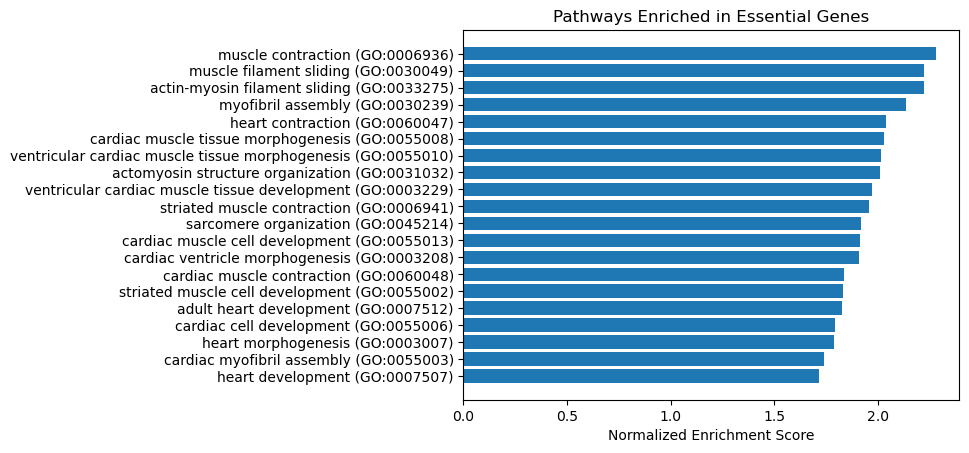

In [10]:
r_e = results[0]

# Sort the rankings by 'nes' in ascending order
r_e_sorted = r_e.sort_values(by='nes', ascending=False)

# Get the top 20 necessary paths for each ranking
good_paths_e = r_e_sorted.iloc[0:20]

fig, ax1 = plt.subplots(1, 1)


gos_e = good_paths_e['Term']
nes_e = abs(good_paths_e['nes'])
y_pos_e = np.arange(len(nes_e))

ax1.barh(y_pos_e, nes_e, align='center')
ax1.set_yticks(y_pos_e, labels=gos_e)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Normalized Enrichment Score')
ax1.set_title('Pathways Enriched in Essential Genes')
plt.savefig('../figures/Fig 3b Essential Pathways')